# Mapping Camera Coordinates to a 2D Floor Plan

This project demonstrates how to map 2D coordinates from a camera image onto a flat 2D floor plan (e.g., top-down map or schematic) using a **homography matrix**.

---

## Goal

Transform pixel coordinates of detected objects (e.g., people, robots, or balls) in a camera view to positions on a flat, scaled 2D map — without needing any physical camera calibration.

---

## How It Works

1. **Load an image** captured from a camera.
2. **Manually select 4 corner points** in the image corresponding to known corners on the map.
3. Define the corresponding corners on your **target 2D map (e.g., 1000×1000 pixels)**.
4. Compute the **homography matrix** using these point pairs.
5. Use the matrix to transform new image points to coordinates on the map.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_image_size(image_path):
    """
    Get the size of an image.

    :param image_path: Path to the image file.
    :return: A tuple containing the width and height of the image.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read the image at {image_path}")
    
    height, width = image.shape[:2]
    return width, height

def show_image(image_path):
    """
    Display an image using matplotlib.

    :param image_path: Path to the image file.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read the image at {image_path}")
    
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

    return image


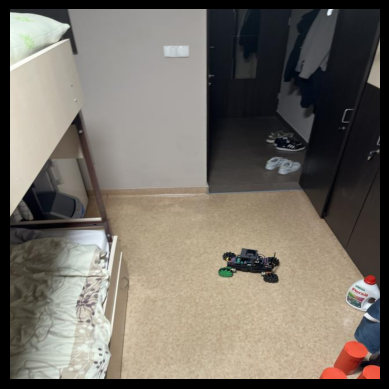

In [3]:
IMG = "../dataset/valid/images/IMG_1254_JPG.rf.3e5d069b50a45684bfe88db34b2c5173.jpg"
MAP_WIDTH = 1000
MAP_HEIGHT = 1000

# Show example image and get its size
image_rgb = show_image(IMG)
image_width, image_height = get_image_size(IMG)

In [13]:
def select_points(image):
    """
    Allow the user to select 4 points on the image.
    The points will be used to define a region of interest.
    :param image: The image on which to select points.
    :return: A tuple (points, annotated_image) where:
             - points is a list of tuples containing the selected points (x, y)
             - annotated_image is a copy of the image with the points drawn on it
    """
    if image is None:
        raise ValueError("Image is None. Please provide a valid image.")
    if not isinstance(image, np.ndarray):
        raise TypeError("Image must be a numpy array.")
    if image.shape[0] == 0 or image.shape[1] == 0:
        raise ValueError("Image is empty. Please provide a valid image.")
    if image.shape[2] != 3:
        raise ValueError("Image must be a 3-channel (RGB) image.")

    points = []
    instructions = [
        "Choose 1 point (top-left)",
        "Choose 2 point (top-right)",
        "Choose 3 point (bottom-left)",
        "Choose 4 point (bottom-right)"
    ]

    def mouse_callback(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN and len(points) < 4:
            points.append((x, y))
            print(f"Chosen point: {x}, {y}")

    clone = image.copy()
    cv2.namedWindow("Click 4 points")
    cv2.setMouseCallback("Click 4 points", mouse_callback)

    while True:
        temp = clone.copy()
        if len(points) < 4:
            cv2.putText(temp, instructions[len(points)], (20, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)

        for idx, p in enumerate(points):
            cv2.circle(temp, p, 5, (0, 0, 255), -1)
            cv2.putText(temp, f"{idx + 1}", (p[0] + 10, p[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        cv2.imshow("Click 4 points", temp)

        if len(points) == 4:
            annotated_image = temp.copy()
            break
        if cv2.waitKey(1) & 0xFF == 27:
            print("Przerwano wybór punktów.")
            cv2.destroyAllWindows()
            return None, None

    cv2.destroyAllWindows()
    return points, annotated_image


Chosen point: 19, 15
Chosen point: 616, 15
Chosen point: 25, 618
Chosen point: 635, 627


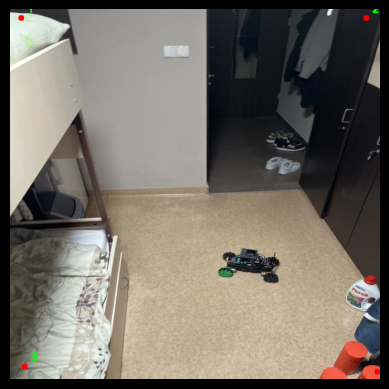

[(19, 15), (616, 15), (25, 618), (635, 627)]

In [32]:
points, img_annotated = select_points(image_rgb)

# Show the image with selected points
plt.imshow(cv2.cvtColor(img_annotated, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
# Calculate the size of the selected area in pixels

points

In [35]:
# Points must be in the same order as they will be used in the homography transformation.
# Source points (on the camera image)
#src_points = np.array([(205, 328), (502, 307), (207, 555), (598, 452)], dtype=np.float32)
src_points = np.array(points, dtype=np.float32)

# Points on the map (destination points) 
dst_points = np.array([
    [1, 1],                 # (top-left)
    [MAP_WIDTH-1, 1],         # (top-right)
    [MAP_WIDTH-1, MAP_HEIGHT-1],# (bottom-right)
    [1, MAP_HEIGHT-1]         # (bottom-left)
], dtype="float32")

# Wywołanie funkcji findHomography z pełną kontrolą nad parametrami
H, mask = cv2.findHomography(src_points,dst_points)

# Wyświetlenie wyników
print("Homography matrix (H):\n", H)
print("Mask of inliers:\n", mask)

Homography matrix (H):
 [[ 1.61564723e+00 -1.62937680e+00 -5.30410118e+00]
 [ 2.33101083e-05 -1.61330094e+00  2.51516154e+01]
 [ 2.33101083e-05 -3.19324170e-03  1.00000000e+00]]
Mask of inliers:
 [[1]
 [1]
 [1]
 [1]]


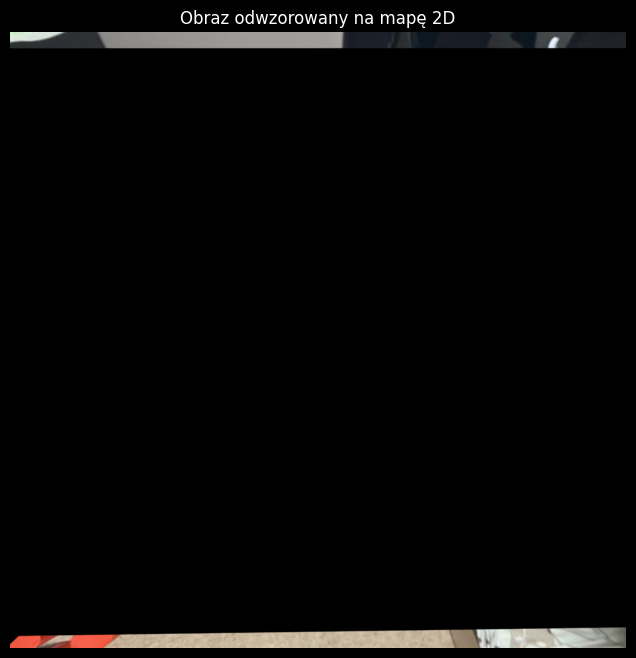

In [36]:
def warp_image_to_map(image_path, H, map_width, map_height):
    # Wczytaj obraz
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Zastosuj perspektywiczne przekształcenie obrazu do przestrzeni mapy
    warped_image = cv2.warpPerspective(
        image, H, (map_width, map_height)
    )

    # Wyświetl wynik
    plt.figure(figsize=(8, 8))
    plt.imshow(warped_image)
    plt.title("Obraz odwzorowany na mapę 2D")
    plt.axis('off')
    plt.show()

    return warped_image

warped = warp_image_to_map(IMG, H, MAP_WIDTH, MAP_HEIGHT)
